# K MEANS

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [9]:
# 1. Load dataset
df = pd.read_csv("/content/titik_panas_indonesia_1_tahun.csv")

In [10]:
# 2. Filter data untuk wilayah Lampung berdasarkan latitude dan longitude
df_lampung = df[
    (df['latitude'] >= -6.75) & (df['latitude'] <= -3.75) &
    (df['longitude'] >= 103.8) & (df['longitude'] <= 105.75)
].copy()

In [11]:
# 3. Map kolom 'confidence' dari kategori ('l','n','h') menjadi angka (0,1,2)
confidence_mapping = {'l': 0, 'n': 1, 'h': 2}
df_lampung['confidence'] = df_lampung['confidence'].map(confidence_mapping)

In [12]:
# 4. Pilih fitur yang akan digunakan untuk clustering
fitur = df_lampung[['latitude', 'longitude','confidence', 'frp']]

In [13]:
# 5. Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fitur)

In [14]:
print("Shape X_scaled:", X_scaled.shape)
print("Jumlah NaN di X_scaled:", np.isnan(X_scaled).sum())

Shape X_scaled: (2536, 4)
Jumlah NaN di X_scaled: 0


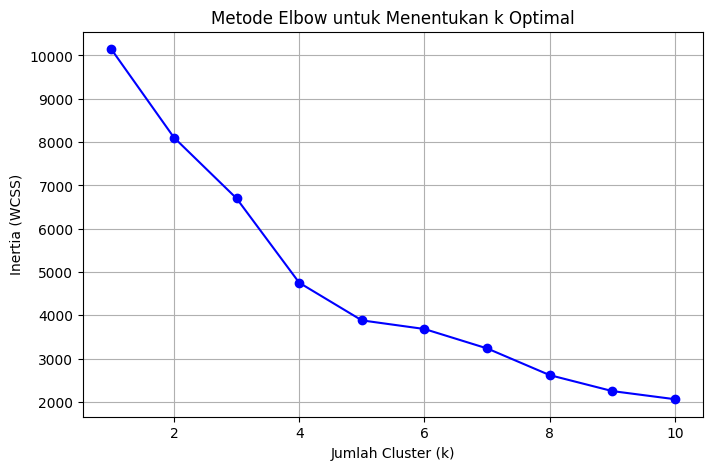

In [15]:
# 6. Tentukan jumlah cluster optimal dengan Metode Elbow
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Metode Elbow untuk Menentukan k Optimal')
plt.grid(True)
plt.show()

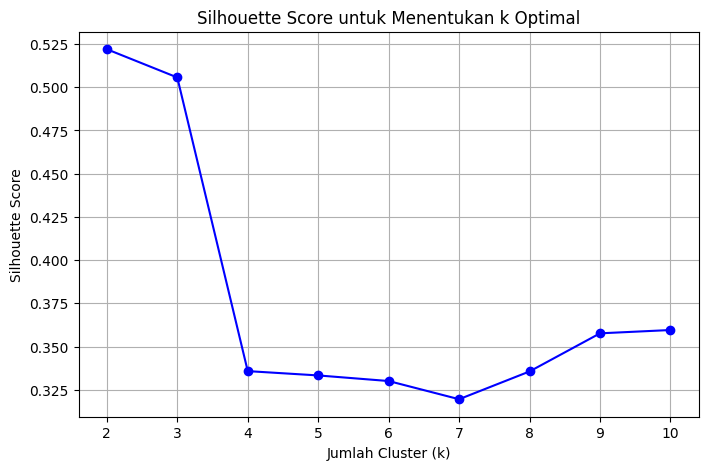

In [16]:
# 7. Tentukan jumlah cluster optimal dengan Silhouette Score
silhouette_scores = []
K_range_sil = range(2, 11)
for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range_sil, silhouette_scores, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Menentukan k Optimal')
plt.grid(True)
plt.show()

In [17]:
# 8. Dari plot Elbow & Silhouette, tentukan nilai k terbaik secara manual
k_optimal = 3

In [18]:
# 9. Jalankan clustering KMeans final dengan k_optimal cluster
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
clusters_final = kmeans_final.fit_predict(X_scaled)

In [19]:
# 10. Tambahkan hasil cluster ke dataframe
df_lampung['cluster'] = clusters_final

In [20]:
# 11. Evaluasi cluster dengan beberapa metrik
sil_score = silhouette_score(X_scaled, clusters_final)
db_score = davies_bouldin_score(X_scaled, clusters_final)
ch_score = calinski_harabasz_score(X_scaled, clusters_final)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")

Silhouette Score: 0.5057
Davies-Bouldin Index: 0.9769
Calinski-Harabasz Score: 651.2065


In [22]:
# 12. Load shapefile provinsi Indonesia (pastikan path benar)
gdf_idn_prov = gpd.read_file("/content/GDAM/gadm41_IDN_2.shp")

In [23]:
# 13. Filter shapefile untuk Provinsi Lampung
gdf_lampung = gdf_idn_prov[gdf_idn_prov['NAME_1'] == 'Lampung']

In [24]:
# 14. Buat GeoDataFrame titik panas dengan geometri titik dari koordinat
gdf_hotspots = gpd.GeoDataFrame(
    df_lampung,
    geometry=gpd.points_from_xy(df_lampung['longitude'], df_lampung['latitude']),
    crs="EPSG:4326"
)

In [25]:
# 15. Spatial join untuk memastikan titik berada dalam wilayah Lampung
gdf_hotspots = gpd.sjoin(gdf_hotspots, gdf_lampung, how="inner", predicate='within')

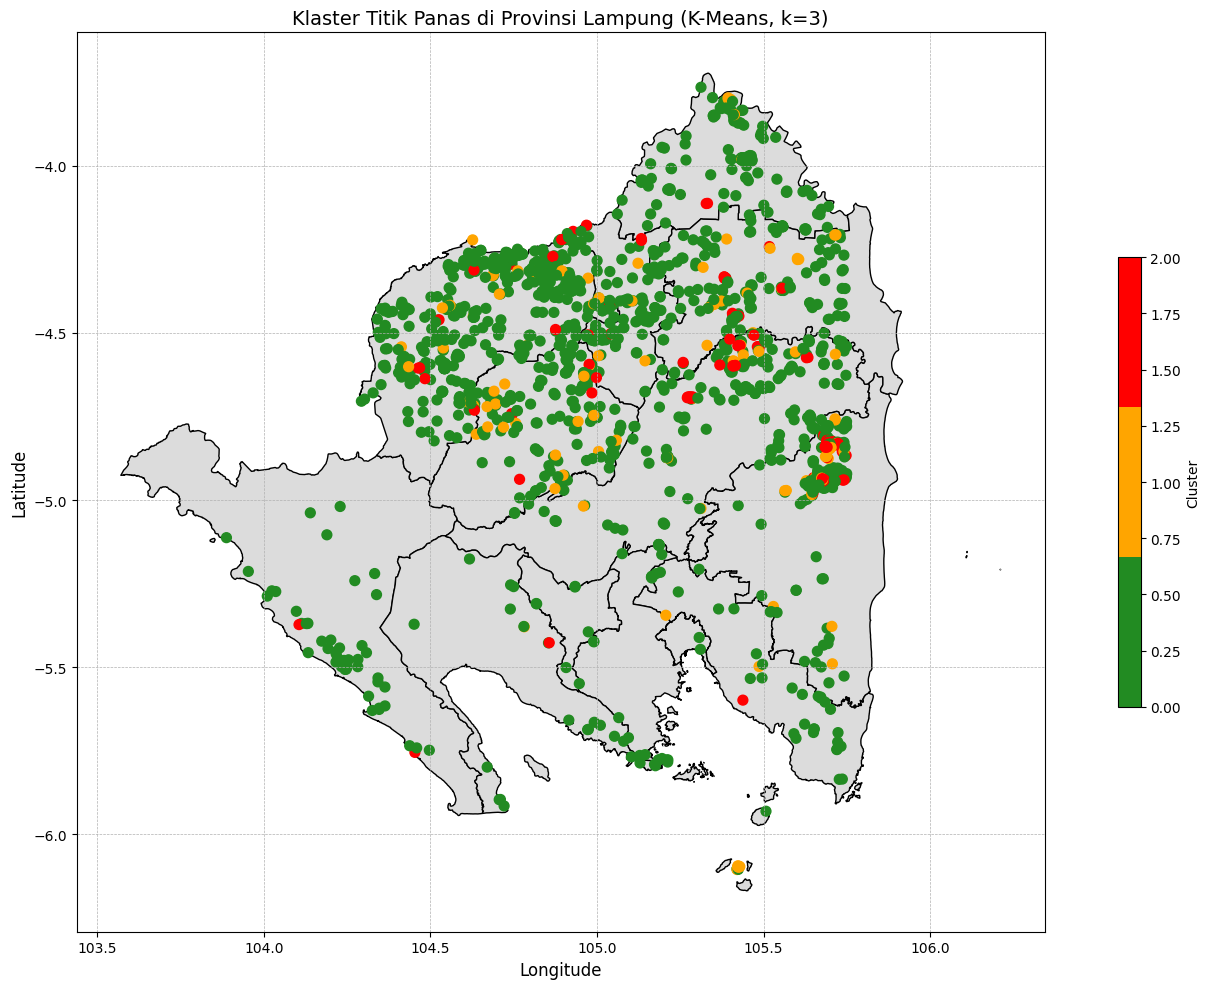

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Load shapefile ---
path = "/content/GDAM/gadm41_IDN_2.shp"
gdf_idn_prov = gpd.read_file(path)

# Filter Provinsi Lampung
gdf_lampung = gdf_idn_prov[gdf_idn_prov['NAME_1'] == 'Lampung']

# Pastikan sistem koordinat sesuai
gdf_lampung = gdf_lampung.to_crs("EPSG:4326")
gdf_hotspots = gdf_hotspots.to_crs("EPSG:4326")  # Pastikan ini juga benar

# Tentukan jumlah cluster dan colormap
k_optimal = gdf_hotspots['cluster'].nunique()
colors = ['forestgreen', 'orange', 'red']
cluster_colors = colors[:k_optimal]
cmap = mcolors.ListedColormap(cluster_colors)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(15, 10))

# Plot wilayah Lampung dengan warna gainsboro dan garis hitam
gdf_lampung.plot(
    ax=ax,
    color='gainsboro',        # Isi wilayah
    edgecolor='black',        # Garis batas
    linewidth=1
)

# Plot titik-titik hotspot berdasarkan cluster
gdf_hotspots.plot(
    ax=ax,
    column='cluster',
    cmap=cmap,
    markersize=50,
    legend=True,
    legend_kwds={'label': "Cluster", 'shrink': 0.5}
)

# Tambahkan label dan grid
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_title(f"Klaster Titik Panas di Provinsi Lampung (K-Means, k={k_optimal})", fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()